In [167]:
#Imports 
import pvlib
from pvlib.location import Location
from pvlib import pvsystem, location, modelchain, iotools
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pathlib
from datetime import datetime
from dataclasses import dataclass

In [168]:
#formatting data 
data = pd.read_csv('tmy_cebive.csv') #Tmy file from JRC 
#data = pd.read_csv('tmy_keyWest.csv') #Tmy file from JRC 
data['index'] = data['time(UTC)'].apply(lambda x: datetime.strptime(x, "%Y%m%d:%H%M"))

# Because tmy file, uses multiple years of data to form the year
# the following lines set the index to the same year for plotting that makes sense 

new_year = 2024 #set to current year 
year_diff = (new_year - data['index'].dt.year) * 365.25 #Year does not work with pandas so has to be in terms of days 
data['index'] = data['index'] + pd.to_timedelta(year_diff, unit='D')

data.set_index('index', inplace=True)
data 


,time(UTC),T2m,RH,G(h),Gb(n),Gd(h),IR(h),WS10m,WD10m,SP
index,,,,,,,,,,
2024-01-01 00:00:00,20080101:0000,23.43,74.80,0.0,-0.00,0.0,385.05,2.62,321.0,101335.0
2024-01-01 01:00:00,20080101:0100,22.72,78.63,0.0,-0.00,0.0,381.54,2.41,331.0,101384.0
2024-01-01 02:00:00,20080101:0200,22.02,82.47,0.0,-0.00,0.0,378.03,2.19,350.0,101434.0
2024-01-01 03:00:00,20080101:0300,21.32,86.30,0.0,-0.00,0.0,374.53,1.98,6.0,101484.0
2024-01-01 04:00:00,20080101:0400,20.61,90.14,0.0,-0.00,0.0,371.02,1.77,358.0,101464.0
...,...,...,...,...,...,...,...,...,...,...
2024-12-31 13:00:00,20091231:1900,26.94,55.62,276.0,41.97,251.0,402.58,3.68,35.0,101384.0
2024-12-31 14:00:00,20091231:2000,26.24,59.46,126.0,0.00,126.0,399.07,3.47,30.0,101375.0
2024-12-31 15:00:00,20091231:2100,25.54,63.29,207.0,544.56,69.0,395.57,3.25,22.0,101384.0


In [169]:
# Class from PVlib seasonal tracking example 
@dataclass
class SeasonalTiltMount(pvsystem.AbstractMount):
    monthly_tilts: list  # length 12, one tilt per calendar month
    surface_azimuth: float = 180.0

    def get_orientation(self, solar_zenith, solar_azimuth):
        tilts = [self.monthly_tilts[m-1] for m in solar_zenith.index.month]
        return pd.DataFrame({
            'surface_tilt': tilts,
            'surface_azimuth': self.surface_azimuth,
        }, index=solar_zenith.index)

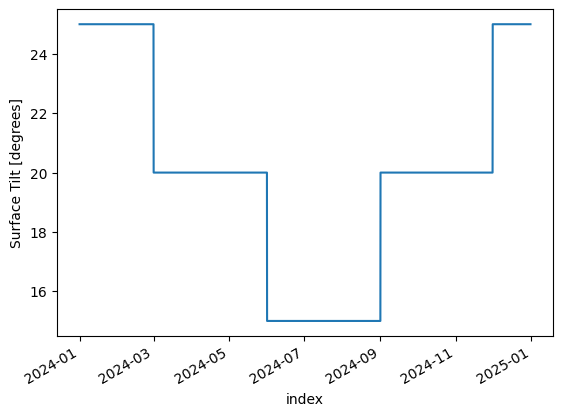

In [170]:
weather = pd.DataFrame({
    'ghi': data['G(h)'], 'dhi': data['Gd(h)'], 'dni': data['Gb(n)'],
    'temp_air':  data['T2m '], 'wind_speed':  data['WS10m'],
})

loc = location.Location(18.541, -69.990, -4.00, 32.0) #lat, long, tz, altitude
#loc = location.Location(24.563, -81.772, -4.00, 4) #Key west

solpos = loc.get_solarposition(weather.index)
# same default monthly tilts as SAM:
tilts = [25, 25, 20, 20, 20, 15, 15, 15, 20, 20, 20, 25] #20 degrees for DR found optimal, +15 in winter and -15 in summer 
mount = SeasonalTiltMount(monthly_tilts=tilts)
orientation = mount.get_orientation(solpos.apparent_zenith, solpos.azimuth)
orientation['surface_tilt'].plot()
plt.ylabel('Surface Tilt [degrees]')
plt.show()

In [171]:
# from PVlib seasonal tracking example 
module_parameters = {'pdc0': 1, 'gamma_pdc': -0.004, 'b': 0.05}
temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
array = pvsystem.Array(mount=mount, module_parameters=module_parameters,
                       temperature_model_parameters=temp_params)
system = pvsystem.PVSystem(arrays=[array], inverter_parameters={'pdc0': 1})
mc = modelchain.ModelChain(system, loc, spectral_model='no_loss')

_ = mc.run_model(weather)

In [172]:
#Fixed mount @ 20 degrees 
array2 = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params)
system2 = pvsystem.PVSystem(arrays=[array2], inverter_parameters={'pdc0': 1})
mc2 = modelchain.ModelChain(system2, loc, spectral_model='no_loss')
_ = mc2.run_model(weather)

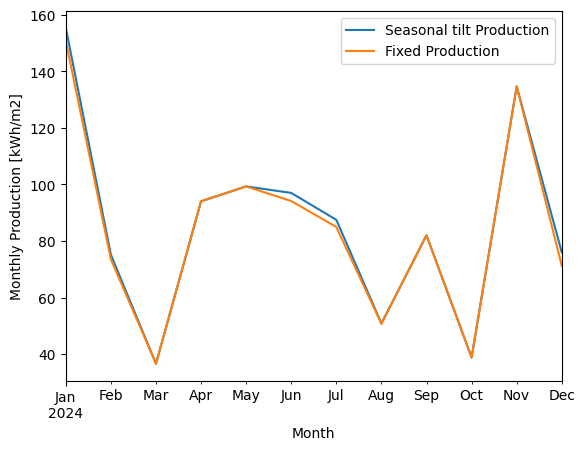

In [173]:
#Plot comparison
results = pd.DataFrame({
    'Seasonal tilt Production': mc.results.ac,
    'Fixed Production': mc2.results.ac,
})
results.resample('m').sum().plot()
plt.ylabel('Monthly Production [kWh/m2]')
plt.xlabel('Month')
plt.show()

In [174]:
# Total Percent Difference 
fixed_results = mc2.results.ac
seasonal_results =mc.results.ac

diff = seasonal_results- fixed_results
total_fixed = sum(fixed_results)
total_seasonal = sum(seasonal_results)
percent_diff = ((total_seasonal-total_fixed)/total_fixed) * 100
print(f"the total yearly percent difference between the production of the fixed and seasonal configuration is {percent_diff}%")

#Max diffeence 
max_diff = max(diff)
print(f'the maximum difference between the fixed versus seasonal generation is {max_diff}W/m2')

the total yearly percent difference between the production of the fixed and seasonal configuration is 1.6408007230993955%
the maximum difference between the fixed versus seasonal generation is 0.15222899779988164W/m2


<Axes: xlabel='index'>

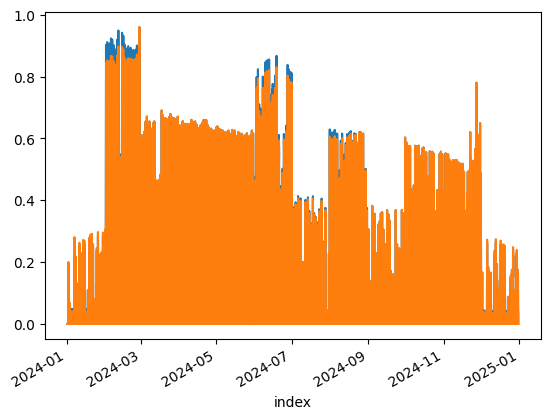

<Axes: xlabel='index'>

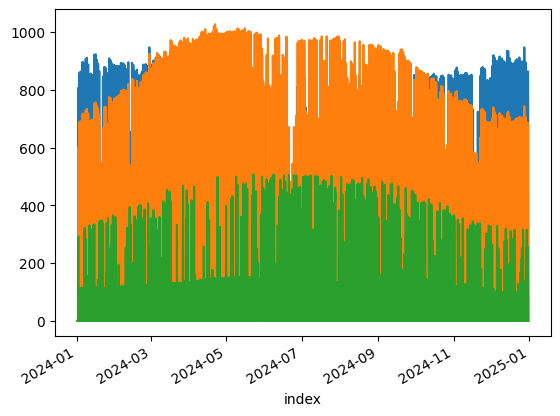

In [ ]:

data['Gb(n)'].plot()
data['G(h)'].plot()
data['Gd(h)'].plot()
